# Project 2: Image Stitcher
## Assigned: 02.01.2019
## Due Date: TBD (probably 02.20.2019)

Panoramic photography is ubiquitous, with nearly every digital camera having a mode dedicated to doing it.  Here's an example from the Italian Alps:
<img src="pano.jpg">
Note the extreme aspect ratio: much larger than the 4:3 or 3:2 that is typical of most cameras; suffice to say, the camera that stook this picture did not have a sensor that was this wide.  So how are these things made?  Stated simply, multiple images are taken, mutually identifiable points are located in each of these images, and the images are warped such that these points are coincident.  The matching stage might look like this:
<img src="office.jpeg">

For this project, you will code your own image stitcher from scratch.  Despite the conceptual simplicity of this operation, there are a surprising number of challenges that need to be addressed.  A general framework for a stitcher might look like this:

In [9]:
import cornermatching_addi as cm
import skimage.transform as skt
import numpy as np

class Stitcher(object):
    def __init__(self,image_1,image_2):
        self.images = [image_1,image_2]
        
    def find_keypoints(self):
        
        # Guass kernel for convolution
        g_kernal = cm.gauss_kernal(5,2)
        
        # Calculate the harris response of each convolution of I1, I2
        H1 = cm.harris_response(cm.convolve(self.images[0], g_kernal))
        H2 = cm.harris_response(cm.convolve(self.images[1], g_kernal))
        
        # Extract the keypoints from H1, H2 via non-maximal sup
        key_pts_I1 = cm.nonmaxsup(H1)
        key_pts_I2 = cm.nonmaxsup(H2)
        
        # Return the keypoints of I1, I2
        return key_pts_I1, key_pts_I2
    
    def generate_descriptors(self):
        
        # Get the keypoints to generate descriptors from
        key_pts_I1, key_pts_I2 = self.find_keypoints()
        
        # Get descriptors for I1, I2
        des_I1 = cm.descriptorExtractor(self.images[0], key_pts_I1)
        des_I2 = cm.descriptorExtractor(self.images[1], key_pts_I2)
        
        return des_I1, des_I2
        """
        Step 2: After identifying relevant keypoints, we need to come up with a quantitative description of the 
        neighborhood of that keypoint, so that we can match it to keypoints in other images.
        """
        
    def match_keypoints(self):
        
        des_I1, des_I2 = self.generate_descriptors()
        
        best_matches = cm.get_best_matches(des_I1, des_I2)
        secondbest_matches = cm.get_secondbest_matches(des_I1, des_I2, best_matches)
        
        
        filtered_matches = cm.filter_matches(best_matches, secondbest_matches)
        
        return filtered_matches, des_I1
    
        """
        Step 3: Compare keypoint descriptions between images, identify potential matches, and filter likely
        mismatches
        """
        
    def find_homography(self):
        
        # Get the matches between the two images
        matches, des_I1 = self.match_keypoints()
        
        # Now get the coordinates from the matches for RANSAC
        match_coords = []
        for match in matches: # filtered_matches:
    
            match_I1_x = des_I1[match[0]][2]

            match_I1_y = des_I1[match[0]][1]
    
            match_I2_x = match[1][2]
    
            match_I2_y = match[1][1]
    
            match_coords.append([match_I1_x,match_I1_y,match_I2_x,match_I2_y])
        
        
        x_offset = [0, 0]
        for match in match_coords:
            if(match[0] > x_offset[0]):
                x_offset = match
        
        # Get the x_offset val from x,y tuple
        x_offset = x_offset[0]
        
   
        # params needed for RANSAC
        
        num_iters = 1000
        r = 3
        d = 3
        n = 4
        
        H_best, list_of_inliers = cm.RANSAC(num_iters, match_coords, n, r, d)
        
        return H_best, x_offset

        
        """
        Step 4: Find a linear transformation (of various complexities) that maps pixels from the second image to 
        pixels in the first image
        """
      
    def stitch(self):
        
        H, x_offset = self.find_homography()
        
        print(H)
        
        proj_trans = skt.ProjectiveTransform(H)
        
        h = len(self.images[0])
        w = len(self.images[0][0])
        new_w = w+(w-x_offset)
        
        image_2_transformed = skt.warp(self.images[1],proj_trans)
        
        #Perform blending of images by taking max val of pixel
        new_image = (self.images[0] + image_2_transformed) / 2
        blended = np.zeros((h,w))
        
        start = 1
        for i in range(start, len(new_image)):
            for j in range(start, len(new_image[i])):
                blended[i][j] = np.average(new_image[i-1:i+1, j-1:j+1])
        

        # Return the blended image
        return new_image
        
        """
        Step 5: Transform second image into local coordinate system of first image, and (perhaps) perform blending
        to avoid obvious seams between images.
        """

We will populate these functions over the next several weeks, a process that will involve delving into some of the most elementary operations in digital signal processing.  

As a test case, apply your stitcher to at least four overlapping images that you've taken.  With a stitcher that works on two images, more images can be added by applying the method recursively.

In [10]:
import matplotlib.pyplot as plt
#def stitchImages():
'''Returns the stiched images recursively'''

images = [plt.imread('im1.jpg').mean(axis=2), plt.imread('im2.jpg').mean(axis=2), plt.imread('im3.jpg').mean(axis=2), plt.imread('im4.jpg').mean(axis=2)]

#filtered_matches, best_matches = image_stitcher.match_keypoints()
image_stitcher = Stitcher(images[0], images[1])
new_image = image_stitcher.stitch()



[[-1.56835692e-02  9.89099111e-03 -3.98587873e-01]
 [-3.61431002e-02  2.27984236e-02 -9.15944467e-01]
 [-7.69176660e-05  4.83525244e-05 -1.88009373e-03]]


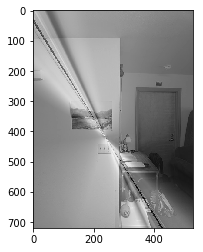

'\nimport numpy as np\nh = int(len(images[0]))\nw = int(len(images[0][0])*2)\ns = (h,w)\nprint(s)\nnew_image = np.zeros(s)\nnew_image[0:h, 0:int(w/2)] = images[0]\nnew_image[0:h, int(w/2):] = images[1]\n\nplt.imshow(new_image, cmap="gray")\nfor match in filtered_matches:\n    x1 = best_matches[match[0]][1]\n    y1 = best_matches[match[0]][2]\n    x2 = match[1][1]\n    y2 = match[1][2]\n    print(x1,y1,x2,y2)\n    plt.plot([y1,y2+int(w/2)], [x1,x2], color="blue", marker="x")\nplt.show()\n'

In [11]:
plt.imshow(new_image, cmap='gray')
plt.show()
'''
import numpy as np
h = int(len(images[0]))
w = int(len(images[0][0])*2)
s = (h,w)
print(s)
new_image = np.zeros(s)
new_image[0:h, 0:int(w/2)] = images[0]
new_image[0:h, int(w/2):] = images[1]

plt.imshow(new_image, cmap="gray")
for match in filtered_matches:
    x1 = best_matches[match[0]][1]
    y1 = best_matches[match[0]][2]
    x2 = match[1][1]
    y2 = match[1][2]
    print(x1,y1,x2,y2)
    plt.plot([y1,y2+int(w/2)], [x1,x2], color="blue", marker="x")
plt.show()
'''

In [4]:
'''
H, list_of_inliers, match_coords = image_stitcher.find_homography()
import skimage.transform as skt
# Create a projective transform based on the homography matrix $H$
proj_trans = skt.ProjectiveTransform(H)

# Warp the image into image 1's coordinate system
#plt.imshow(images[0], cmap="gray")
#plt.show()
'''

'\nH, list_of_inliers, match_coords = image_stitcher.find_homography()\nimport skimage.transform as skt\n# Create a projective transform based on the homography matrix $H$\nproj_trans = skt.ProjectiveTransform(H)\n\n# Warp the image into image 1\'s coordinate system\n#plt.imshow(images[0], cmap="gray")\n#plt.show()\n'

In [5]:
'''
import numpy as np

print(H)
print(list_of_inliers)
image_2_transformed = skt.warp(image_stitcher.images[1],proj_trans)
plt.imshow(images[1], cmap="gray")
plt.show()
plt.imshow(image_2_transformed, cmap="gray")
for inlier in list_of_inliers:
    plt.plot(inlier[0], inlier[1], marker="x")
plt.show()

plt.imshow(images[0], cmap="gray")
for inlier in list_of_inliers:
    plt.plot(inlier[0], inlier[1], marker="x")
plt.show()
'''

'\nimport numpy as np\n\nprint(H)\nprint(list_of_inliers)\nimage_2_transformed = skt.warp(image_stitcher.images[1],proj_trans)\nplt.imshow(images[1], cmap="gray")\nplt.show()\nplt.imshow(image_2_transformed, cmap="gray")\nfor inlier in list_of_inliers:\n    plt.plot(inlier[0], inlier[1], marker="x")\nplt.show()\n\nplt.imshow(images[0], cmap="gray")\nfor inlier in list_of_inliers:\n    plt.plot(inlier[0], inlier[1], marker="x")\nplt.show()\n'

In [6]:
'''
match_I1 = []
match_I2 = []
for coord in match_coords:
    match_I1.append([coord[0], coord[1]])
    match_I2.append([coord[2], coord[3]])
'''

'\nmatch_I1 = []\nmatch_I2 = []\nfor coord in match_coords:\n    match_I1.append([coord[0], coord[1]])\n    match_I2.append([coord[2], coord[3]])\n'

In [7]:
'''plt.imshow(images[0], cmap="gray")
for match in match_I1:
    plt.plot(match[0], match[1], marker = 'x')
plt.show()

plt.imshow(images[1], cmap="gray")
for match in match_I2:
    plt.plot(match[0], match[1], marker = 'x')
plt.show()

new_image = (images[0] + image_2_transformed) / 2
plt.imshow(new_image, cmap="gray")
plt.show()
'''

'plt.imshow(images[0], cmap="gray")\nfor match in match_I1:\n    plt.plot(match[0], match[1], marker = \'x\')\nplt.show()\n\nplt.imshow(images[1], cmap="gray")\nfor match in match_I2:\n    plt.plot(match[0], match[1], marker = \'x\')\nplt.show()\n\nnew_image = (images[0] + image_2_transformed) / 2\nplt.imshow(new_image, cmap="gray")\nplt.show()\n'